Загрузка данных с Binance...
Загружено записей: 1000
Загружено записей: 2000
Загружено записей: 3000
Загружено записей: 4000
Загружено записей: 5000
Загружено записей: 6000
Загружено записей: 7000
Загружено записей: 8000
Загружено записей: 9000
Загружено записей: 10000
Загружено записей: 11000
Загружено записей: 12000
Загружено записей: 13000
Загружено записей: 14000
Загружено записей: 15000
Загружено записей: 16000
Загружено записей: 17000
Загружено записей: 18000
Загружено записей: 19000
Загружено записей: 20000
Загружено записей: 21000
Загружено записей: 22000
Загружено записей: 23000
Загружено записей: 24000
Загружено записей: 25000
Загружено записей: 26000
Загружено записей: 27000
Загружено записей: 28000
Загружено записей: 29000
Загружено записей: 30000
Загружено записей: 31000
Загружено записей: 32000
Загружено записей: 33000
Загружено записей: 34000
Загружено записей: 35000
Загружено записей: 36000
Загружено записей: 37000
Загружено записей: 38000
Загружено записей: 39000
Загру

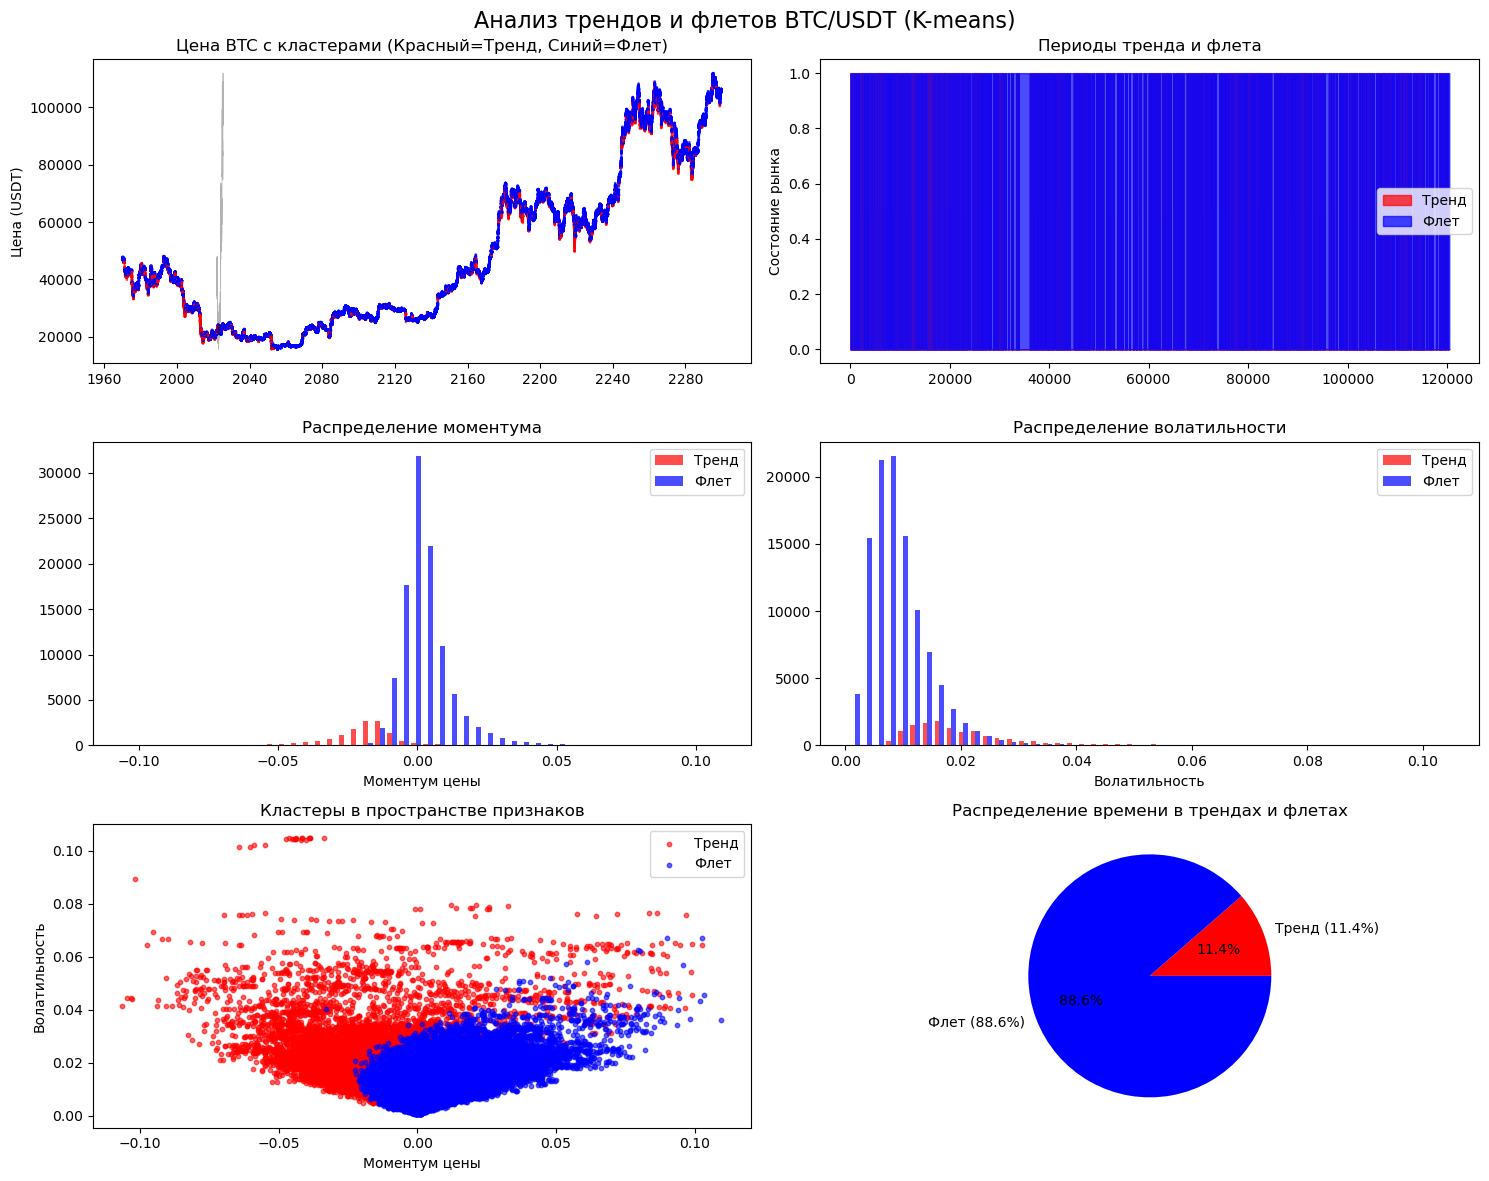

In [4]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

class BTCTrendAnalyzer:
    def __init__(self):
        self.data = None
        self.features = None
        self.scaler = StandardScaler()
        
    def get_binance_data(self, symbol: str = "BTCUSDT", interval: str = "15m", 
                        start_date: str = "2022-01-01", end_date: str = "2025-06-09") -> pd.DataFrame:
        """
        Получение данных с Binance API
        """
        # Конвертация дат в timestamp
        start_timestamp = int(datetime.strptime(start_date, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp() * 1000)
        end_timestamp = int(datetime.strptime(end_date, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp() * 1000)
        
        # URL для Binance API
        url = "https://api.binance.com/api/v3/klines"
        
        all_data = []
        current_start = start_timestamp
        
        print("Загрузка данных с Binance...")
        
        # Binance ограничивает количество свечей за запрос (макс 1000)
        while current_start < end_timestamp:
            params = {
                'symbol': symbol,
                'interval': interval,
                'startTime': current_start,
                'endTime': end_timestamp,
                'limit': 1000
            }
            
            response = requests.get(url, params=params)
            if response.status_code != 200:
                raise Exception(f"Ошибка API: {response.status_code}")
            
            data = response.json()
            if not data:
                break
                
            all_data.extend(data)
            
            # Обновляем стартовую дату для следующего запроса
            last_timestamp = data[-1][0]
            current_start = last_timestamp + 1
            
            print(f"Загружено записей: {len(all_data)}")
        
        # Создание DataFrame
        df = pd.DataFrame(all_data, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'number_of_trades',
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
        ])
        
        # Конвертация типов данных
        numeric_columns = ['open', 'high', 'low', 'close', 'volume']
        for col in numeric_columns:
            df[col] = pd.to_numeric(df[col])
        
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        
        print(f"Загружено {len(df)} свечей с {df.index[0]} по {df.index[-1]}")
        return df
    
    def calculate_technical_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Расчет технических индикаторов для анализа тренда
        """
        data = df.copy()
        
        # Скользящие средние
        data['SMA_20'] = data['close'].rolling(window=20).mean()
        data['SMA_50'] = data['close'].rolling(window=50).mean()
        data['EMA_12'] = data['close'].ewm(span=12).mean()
        data['EMA_26'] = data['close'].ewm(span=26).mean()
        
        # MACD
        data['MACD'] = data['EMA_12'] - data['EMA_26']
        data['MACD_signal'] = data['MACD'].ewm(span=9).mean()
        data['MACD_histogram'] = data['MACD'] - data['MACD_signal']
        
        # RSI
        delta = data['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        data['RSI'] = 100 - (100 / (1 + rs))
        
        # Bollinger Bands
        data['BB_middle'] = data['close'].rolling(window=20).mean()
        bb_std = data['close'].rolling(window=20).std()
        data['BB_upper'] = data['BB_middle'] + (bb_std * 2)
        data['BB_lower'] = data['BB_middle'] - (bb_std * 2)
        data['BB_width'] = data['BB_upper'] - data['BB_lower']
        data['BB_position'] = (data['close'] - data['BB_lower']) / (data['BB_upper'] - data['BB_lower'])
        
        # Волатильность
        data['volatility'] = data['close'].pct_change().rolling(window=20).std() * np.sqrt(20)
        
        # Силы тренда
        data['price_momentum'] = data['close'].pct_change(periods=20)
        data['volume_sma'] = data['volume'].rolling(window=20).mean()
        data['volume_ratio'] = data['volume'] / data['volume_sma']
        
        # ADX (упрощенная версия)
        high_low = data['high'] - data['low']
        high_close = np.abs(data['high'] - data['close'].shift())
        low_close = np.abs(data['low'] - data['close'].shift())
        true_range = np.maximum(high_low, np.maximum(high_close, low_close))
        data['ATR'] = true_range.rolling(window=14).mean()
        
        return data
    
    def prepare_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Подготовка признаков для кластеризации
        """
        # Основные признаки для определения тренда/флета
        features = pd.DataFrame()
        
        # 1. Направление тренда
        features['sma_slope'] = data['SMA_20'].diff(5) / data['close']  # Наклон SMA
        features['price_momentum'] = data['price_momentum']
        
        # 2. Сила тренда
        features['macd_strength'] = np.abs(data['MACD']) / data['close']
        features['rsi_deviation'] = np.abs(data['RSI'] - 50) / 50  # Отклонение RSI от нейтрали
        
        # 3. Волатильность и разброс
        features['volatility'] = data['volatility']
        features['bb_width_norm'] = data['BB_width'] / data['close']  # Нормализованная ширина BB
        features['bb_position'] = data['BB_position']
        
        # 4. Объемные характеристики
        features['volume_ratio'] = data['volume_ratio']
        
        # 5. Консистентность движения
        features['close_to_sma_ratio'] = data['close'] / data['SMA_20']
        features['atr_ratio'] = data['ATR'] / data['close']
        
        # Удаление строк с NaN
        features = features.dropna()
        
        return features
    
    def perform_clustering(self, features: pd.DataFrame, n_clusters: int = 2) -> Tuple[np.ndarray, KMeans]:
        """
        Выполнение кластеризации K-means
        """
        # Стандартизация признаков
        features_scaled = self.scaler.fit_transform(features)
        
        # K-means кластеризация
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(features_scaled)
        
        return clusters, kmeans
    
    def analyze_clusters(self, features: pd.DataFrame, clusters: np.ndarray) -> Dict:
        """
        Анализ полученных кластеров
        """
        # Добавляем кластеры к признакам
        cluster_data = features.copy()
        cluster_data['cluster'] = clusters
        
        # Анализ характеристик кластеров
        cluster_stats = {}
        
        for cluster_id in range(len(np.unique(clusters))):
            cluster_subset = cluster_data[cluster_data['cluster'] == cluster_id]
            
            # Средние значения признаков для кластера
            stats = {
                'count': len(cluster_subset),
                'percentage': len(cluster_subset) / len(cluster_data) * 100,
                'avg_momentum': cluster_subset['price_momentum'].mean(),
                'avg_volatility': cluster_subset['volatility'].mean(),
                'avg_sma_slope': cluster_subset['sma_slope'].mean(),
                'avg_rsi_deviation': cluster_subset['rsi_deviation'].mean(),
                'avg_bb_width': cluster_subset['bb_width_norm'].mean(),
                'avg_macd_strength': cluster_subset['macd_strength'].mean()
            }
            
            cluster_stats[f'cluster_{cluster_id}'] = stats
        
        # Определение, какой кластер соответствует тренду, а какой - флету
        trend_cluster = 0
        flat_cluster = 1
        
        # Кластер с большим моментумом и наклоном SMA = тренд
        if (cluster_stats['cluster_0']['avg_momentum'] > cluster_stats['cluster_1']['avg_momentum'] and
            abs(cluster_stats['cluster_0']['avg_sma_slope']) > abs(cluster_stats['cluster_1']['avg_sma_slope'])):
            trend_cluster = 0
            flat_cluster = 1
        else:
            trend_cluster = 1
            flat_cluster = 0
        
        cluster_stats['trend_cluster'] = trend_cluster
        cluster_stats['flat_cluster'] = flat_cluster
        
        return cluster_stats
    
    def visualize_results(self, data: pd.DataFrame, features: pd.DataFrame, clusters: np.ndarray, cluster_stats: Dict):
        """
        Визуализация результатов анализа
        """
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle('Анализ трендов и флетов BTC/USDT (K-means)', fontsize=16)
        
        # Общий график цены с раскраской по кластерам
        aligned_data = data.loc[features.index]
        colors = ['red' if c == cluster_stats['trend_cluster'] else 'blue' for c in clusters]
        
        axes[0, 0].scatter(range(len(aligned_data)), aligned_data['close'], c=colors, alpha=0.6, s=1)
        axes[0, 0].plot(aligned_data['close'], color='black', alpha=0.3, linewidth=0.5)
        axes[0, 0].set_title('Цена BTC с кластерами (Красный=Тренд, Синий=Флет)')
        axes[0, 0].set_ylabel('Цена (USDT)')
        
        # Распределение кластеров во времени
        cluster_series = pd.Series(clusters, index=features.index)
        trend_periods = cluster_series == cluster_stats['trend_cluster']
        
        axes[0, 1].fill_between(range(len(trend_periods)), 0, trend_periods.astype(int), 
                               alpha=0.7, color='red', label='Тренд')
        axes[0, 1].fill_between(range(len(trend_periods)), 0, (~trend_periods).astype(int), 
                               alpha=0.7, color='blue', label='Флет')
        axes[0, 1].set_title('Периоды тренда и флета')
        axes[0, 1].set_ylabel('Состояние рынка')
        axes[0, 1].legend()
        
        # Гистограмма моментума по кластерам
        trend_momentum = features.loc[clusters == cluster_stats['trend_cluster'], 'price_momentum']
        flat_momentum = features.loc[clusters == cluster_stats['flat_cluster'], 'price_momentum']
        
        axes[1, 0].hist([trend_momentum, flat_momentum], bins=50, alpha=0.7, 
                       color=['red', 'blue'], label=['Тренд', 'Флет'])
        axes[1, 0].set_title('Распределение моментума')
        axes[1, 0].set_xlabel('Моментум цены')
        axes[1, 0].legend()
        
        # Волатильность по кластерам
        trend_volatility = features.loc[clusters == cluster_stats['trend_cluster'], 'volatility']
        flat_volatility = features.loc[clusters == cluster_stats['flat_cluster'], 'volatility']
        
        axes[1, 1].hist([trend_volatility, flat_volatility], bins=50, alpha=0.7,
                       color=['red', 'blue'], label=['Тренд', 'Флет'])
        axes[1, 1].set_title('Распределение волатильности')
        axes[1, 1].set_xlabel('Волатильность')
        axes[1, 1].legend()
        
        # Scatter plot признаков
        axes[2, 0].scatter(features.loc[clusters == cluster_stats['trend_cluster'], 'price_momentum'],
                          features.loc[clusters == cluster_stats['trend_cluster'], 'volatility'],
                          c='red', alpha=0.6, label='Тренд', s=10)
        axes[2, 0].scatter(features.loc[clusters == cluster_stats['flat_cluster'], 'price_momentum'],
                          features.loc[clusters == cluster_stats['flat_cluster'], 'volatility'],
                          c='blue', alpha=0.6, label='Флет', s=10)
        axes[2, 0].set_xlabel('Моментум цены')
        axes[2, 0].set_ylabel('Волатильность')
        axes[2, 0].set_title('Кластеры в пространстве признаков')
        axes[2, 0].legend()
        
        # Статистика кластеров
        trend_pct = cluster_stats[f'cluster_{cluster_stats["trend_cluster"]}']['percentage']
        flat_pct = cluster_stats[f'cluster_{cluster_stats["flat_cluster"]}']['percentage']
        
        axes[2, 1].pie([trend_pct, flat_pct], labels=[f'Тренд ({trend_pct:.1f}%)', f'Флет ({flat_pct:.1f}%)'],
                      colors=['red', 'blue'], autopct='%1.1f%%')
        axes[2, 1].set_title('Распределение времени в трендах и флетах')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def print_analysis_report(self, cluster_stats: Dict):
        """
        Вывод отчета по анализу
        """
        print("="*60)
        print("ОТЧЕТ ПО АНАЛИЗУ ТРЕНДОВ BTC/USDT")
        print("="*60)
        
        trend_cluster_id = cluster_stats['trend_cluster']
        flat_cluster_id = cluster_stats['flat_cluster']
        
        trend_stats = cluster_stats[f'cluster_{trend_cluster_id}']
        flat_stats = cluster_stats[f'cluster_{flat_cluster_id}']
        
        print(f"\n📈 ТРЕНДОВЫЕ ПЕРИОДЫ (Кластер {trend_cluster_id}):")
        print(f"   Время в тренде: {trend_stats['percentage']:.1f}%")
        print(f"   Количество периодов: {trend_stats['count']}")
        print(f"   Средний моментум: {trend_stats['avg_momentum']:.4f}")
        print(f"   Средняя волатильность: {trend_stats['avg_volatility']:.4f}")
        print(f"   Средний наклон SMA: {trend_stats['avg_sma_slope']:.6f}")
        print(f"   Средняя сила MACD: {trend_stats['avg_macd_strength']:.6f}")
        
        print(f"\n📊 ФЛЕТОВЫЕ ПЕРИОДЫ (Кластер {flat_cluster_id}):")
        print(f"   Время во флете: {flat_stats['percentage']:.1f}%")
        print(f"   Количество периодов: {flat_stats['count']}")
        print(f"   Средний моментум: {flat_stats['avg_momentum']:.4f}")
        print(f"   Средняя волатильность: {flat_stats['avg_volatility']:.4f}")
        print(f"   Средний наклон SMA: {flat_stats['avg_sma_slope']:.6f}")
        print(f"   Средняя сила MACD: {flat_stats['avg_macd_strength']:.6f}")
        
        print(f"\n🎯 КЛЮЧЕВЫЕ ВЫВОДЫ:")
        if trend_stats['percentage'] > flat_stats['percentage']:
            print(f"   • Рынок больше времени проводит в ТРЕНДОВОМ состоянии")
        else:
            print(f"   • Рынок больше времени проводит в ФЛЕТОВОМ состоянии")
        
        momentum_diff = abs(trend_stats['avg_momentum'] - flat_stats['avg_momentum'])
        volatility_diff = abs(trend_stats['avg_volatility'] - flat_stats['avg_volatility'])
        
        print(f"   • Разница в моментуме между трендом и флетом: {momentum_diff:.4f}")
        print(f"   • Разница в волатильности: {volatility_diff:.4f}")
        
        print("="*60)
    
    def run_analysis(self):
        """
        Основной метод для запуска анализа
        """
        # 1. Загрузка данных
        self.data = self.get_binance_data()
        
        # 2. Расчет технических индикаторов
        self.data = self.calculate_technical_indicators(self.data)
        
        # 3. Подготовка признаков
        self.features = self.prepare_features(self.data)
        
        # 4. Кластеризация
        clusters, kmeans_model = self.perform_clustering(self.features)
        
        # 5. Анализ кластеров
        cluster_stats = self.analyze_clusters(self.features, clusters)
        
        # 6. Вывод результатов
        self.print_analysis_report(cluster_stats)
        
        # 7. Визуализация
        self.visualize_results(self.data, self.features, clusters, cluster_stats)
        
        return {
            'data': self.data,
            'features': self.features,
            'clusters': clusters,
            'cluster_stats': cluster_stats,
            'model': kmeans_model
        }

# Запуск анализа
if __name__ == "__main__":
    analyzer = BTCTrendAnalyzer()
    results = analyzer.run_analysis()